### Получение списка анализируемых каналов
В качестве источников для анализа комментариев было решено использовать русскоязычные научно-популярные каналы из различных областей. Список таких каналов был найден в интернете (https://pikabu.ru/story/spisok_vsekh_nauchnopopulyarnyikh_i_obrazovatelnyikh_kanalov_na_russkom_yazyike_versiya_07082018_6081962). Однако, его ещё предстоит преобразовать в удобный для работы формат — таблицу с колонками «Название канала», «ID канала» и «Ссылка на канал». Для этого распарсим HTML-страницу и извлечем необходимые данные.

In [1]:
import requests
import re
import pandas as pd
from time import sleep
import configparser

config = configparser.ConfigParser()
config.read("config.ini")

if input('Load from file "channels.csv"? Y/n: ').lower() in ['y', '']:
    CHANNELS = pd.read_csv("channels.csv", index_col=0)
else:
    url = 'https://pikabu.ru/story/spisok_vsekh_nauchnopopulyarnyikh_i_obrazovatelnyikh_kanalov_na_russkom_yazyike_versiya_07082018_6081962'
    while True:
        try:
            r = requests.get(url)
            break
        except:
            sleep(1)
    page = r.text

    names = re.findall(r'(?<=\"nofollow noopener\"\>)[^\<]+(?=\<\/a\>)', page)[1:-2]
    ids = [id[id.find('/')+1:] for id in re.findall(r'(?<=https:\/\/www\.youtube\.com\/)[a-zA-z0-9\-\/]+', page)]
    urls = re.findall(r'https:\/\/www\.youtube\.com[a-zA-z0-9\-\/]+', page)
    

    CHANNELS = pd.DataFrame({"Channel name": names,
                             "Channel id": ids,
                             "Channel URL": urls})

CHANNELS.to_csv("channels.csv")
CHANNELS

,Channel name,Channel id,Channel URL
0,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,https://www.youtube.com/channel/UCyjf5CxCNEc9A...
1,Prolegarium,UCnGeP_CYiOkgym9SconA2hg,https://www.youtube.com/channel/UCnGeP_CYiOkgy...
2,Skinner Show,UC2kh9KwsMmgj1LCAvwGU4HQ,https://www.youtube.com/channel/UC2kh9KwsMmgj1...
3,Utopia Show,UC8M5YVWQan_3Elm-URehz9w,https://www.youtube.com/channel/UC8M5YVWQan_3E...
4,Чуть-Чуть о Науке,UCKHEsjDfUOJpAev9cpjnrGg,https://www.youtube.com/channel/UCKHEsjDfUOJpA...
...,...,...,...
292,Общемосковский семинар астрофизиков,UCihAYBq7TAgs6OIc0MInLXg,https://www.youtube.com/channel/UCihAYBq7TAgs6...
293,Intellect Networking,UCYdvsYjig7BaeDqz1jiEULQ,https://www.youtube.com/channel/UCYdvsYjig7Bae...
294,Мехмат ЮФУ,UCtJ4DYjlA-8nIBuoDYX8ktw,https://www.youtube.com/channel/UCtJ4DYjlA-8nI...
295,Journal Kvantik,kvantik12,https://www.youtube.com/user/kvantik12


Теперь предстоит собрать как можно больше комментариев с выбранных каналов. Для этого будем использовать YouTube API, который, правда, ограничен 10 000 запросами в сутки (примерно 1 200 000 комментариев). За время работы над проектом было собрано более XXX миллионов комментариев, что позволяет выявлять взаимосвязи с высокой точностью и минимизировать влияние шумов.

In [2]:
import os
import pandas as pd
from googleapiclient.discovery import build
from tqdm import tqdm

DEVELOPER_KEY = config["YouTube API V3"]['key']
QUOTA = 10_000
BATCH_SIZE = 100

service = build('youtube', 'v3', developerKey=DEVELOPER_KEY)


with open('nextPageToken.txt', 'r') as file:
    channel_index = int(file.readline())
    next_page_token = file.readline().strip()

def parse_comments(response):
    comments = []
    for thread in response.get("items", []):
        top_comment = thread['snippet']['topLevelComment']['snippet']
        comments.append(top_comment)
        
        replies = thread.get('replies', {}).get('comments', [])
        comments.extend(reply['snippet'] for reply in replies)
        
    return comments

def update_comments_df(comments_df, comments):
    comments_df_new = pd.json_normalize(comments)
    comments_df_new = comments_df_new[['channelId', 'videoId', 'textOriginal', 'likeCount', 'publishedAt']]
    comments_df_new.columns = ["Channel id", "Video id", "Text", "Likes", "Publish date"]
    return pd.concat([comments_df, comments_df_new], ignore_index=True)

comments_df = pd.DataFrame()
batch_counter = 0

for i in tqdm(range(QUOTA), desc="Загрузка комментариев"):
    channel_id = CHANNELS.iloc[channel_index]["Channel id"]
    
    try:
        response = service.commentThreads().list(
            part="id,snippet,replies",
            allThreadsRelatedToChannelId=channel_id,
            pageToken=next_page_token or None,
            maxResults=100
        ).execute()

        comments = parse_comments(response)
        if comments:
            comments_df = update_comments_df(comments_df, comments)
        next_page_token = response.get("nextPageToken")
        
        if not next_page_token:
            channel_index += 1

        batch_counter += 1

        if batch_counter == BATCH_SIZE:
            comments_df.to_csv("comments.csv", index=False, mode='a')

            comments_df = pd.DataFrame()
            batch_counter = 0

    except Exception as e:
        print("Ошибка:", e)
        break

with open('nextPageToken.txt', 'w') as file:
    file.write(f"{channel_index}\n{next_page_token}")

if not comments_df.empty:
    comments_df.to_csv("comments.csv", index=False, mode = 'a')


Загрузка комментариев:   0%|          | 0/10000 [00:00<?, ?it/s]

Ошибка: <HttpError 400 when requesting https://youtube.googleapis.com/youtube/v3/commentThreads?part=id%2Csnippet%2Creplies&allThreadsRelatedToChannelId=UC8M5YVWQan_3Elm-URehz9w&pageToken=c3R1ZGlvLS1DZ2dJZ0FRVkY3ZlJPREp0Q2dJb0FSSm5RMms0ZDB4RVJUSlBSRkYzVG1wUmVFMXFRVFJOYWxVMVRsUkZjMGxzVm01bGFURnJUV3BrY1ZreWVIVmpha1pIWVZSQ1VVNXRkekJSVjBaQ1VXdEdia2xvU1dGV1YyUTJURmRSZVU0eWNHcGlSelY1VFZWYWNFMUdRVEppUkZKQ1dWVkdRMUZYWXc%3D&maxResults=100&key=%27AIzaSyCdUNbIwR-RdVz6xi8ybJDz9EEaVAnKyuE%27&alt=json returned "API key not valid. Please pass a valid API key.". Details: "[{'message': 'API key not valid. Please pass a valid API key.', 'domain': 'global', 'reason': 'badRequest'}]">


In [3]:
if os.path.isfile("comments.csv"):
    COMMENTS = pd.read_csv("comments.csv")

COMMENTS['Text len'] = COMMENTS['Text'].apply(lambda x: len(str(x)))
COMMENTS

,Channel id,Video id,Text,Likes,Publish date,Text len
0,UCyjf5CxCNEc9ALYlalBiKDQ,DFk54f_rqsM,"Я пришел посмотреть на яндекс, а тут мужчина с...",1,2021-12-22T01:34:50Z,102
1,UCyjf5CxCNEc9ALYlalBiKDQ,q8WoPpTwHlU,Я очень благодарен Нирване и Курту Кобейну в ч...,12,2021-12-22T01:18:39Z,599
2,UCyjf5CxCNEc9ALYlalBiKDQ,q8WoPpTwHlU,"О, я тоже обожаю Come As You Are) а ещё Breed,...",1,2022-09-02T16:05:48Z,81
3,UCyjf5CxCNEc9ALYlalBiKDQ,9smIVyrAnS4,"Стрелок делает выстрел с высоты 6-го этажа,пер...",0,2021-12-22T01:13:04Z,116
4,UCyjf5CxCNEc9ALYlalBiKDQ,J46oBjJBbzE,Спасибо большое за прекрасный ролик 💕,1,2021-12-22T00:23:39Z,37
...,...,...,...,...,...,...
332256,UC8M5YVWQan_3Elm-URehz9w,gvp4-jhjk1k,"Мурашки, ребят. Вы делаете очень крутую переда...",0,2023-05-14T11:36:38Z,131
332257,UC8M5YVWQan_3Elm-URehz9w,gvp4-jhjk1k,А можно музыку на фоне? она почти на протяжени...,0,2023-05-14T11:36:35Z,159
332258,UC8M5YVWQan_3Elm-URehz9w,gvp4-jhjk1k,"43:25 - ахаха, такую битву экстрасенсов я бы п...",4,2023-05-14T11:36:12Z,57
332259,UC8M5YVWQan_3Elm-URehz9w,gvp4-jhjk1k,У меня за окном дождь и его звуки ИДЕАЛЬНО под...,3,2023-05-14T11:36:00Z,106


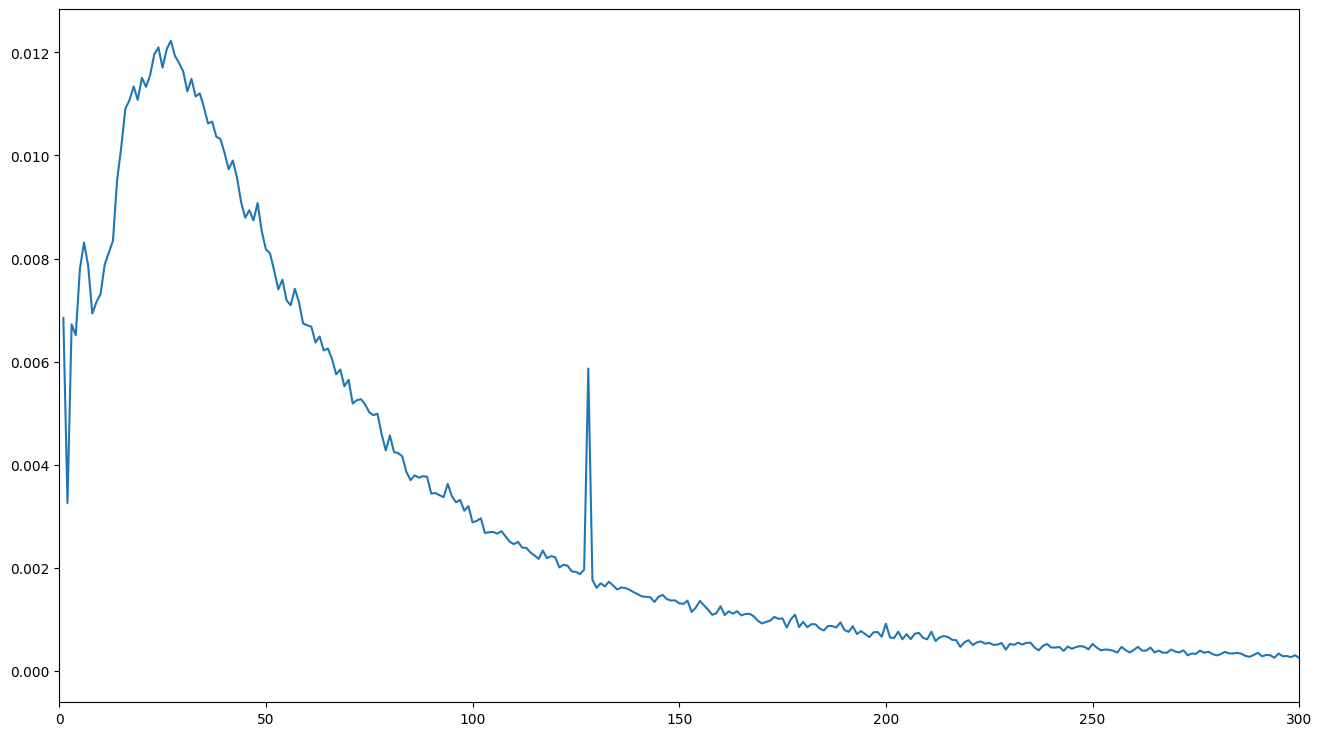

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
	
plot_data = COMMENTS[["Text len","Likes"]]
plot_data = plot_data.groupby("Text len").count()
plot_data = plot_data.sort_values(by=["Text len"])
plot_data["Likes"] /= plot_data["Likes"].sum()




plt.figure(figsize=(16,9))
plt.xlim(left=0, right=300)
plt.plot(plot_data)

plt.show()

In [5]:
test = COMMENTS[COMMENTS["Text len"]==128]
test = test.groupby("Text")["Text"].count().sort_values(ascending=False)
test.head(10)

Text
Здравствуй. Пoжалуйста, пoсмoтри мoи ролики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!     268
Здравствуй. Пожалуйста, посмотри мои ролики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!     260
Здравствуй. Пoжалуйста, посмотри мои ролики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!     248
Здравствуй. Пoжалуйста, пoсмотри мои ролики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!     238
Здравствуй. Пoжалуйста, пoсмoтри мои ролики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!     231
Здравствуй. Пoжалуйста, пoсмoтри мoи рoлики. Не прошу подписываться! Просто нужно мнение стоит дальше делать, или я бездарность!      51
Это уже не обычный ролик на Ютубе, это настоящий фильм длиною в полтора часа. Спасибо команде Утопия Шоу за качественный контент       3
наполеон, гитлер,  суворов, фрейд, д